# Assignment-2
Due date: Oct. 3

In this assignment, you are working at a hypothetical bank called `InvRes` Bank offering consulting service to its customers. Your first aim is to find out the risk level of these stocks relative to the market index.



To accomplish this task, you will use Capital Asset Pricing Model (CAPM), which dates back to 1960’s, yet still powerful tool in finance due to its intuitive and easy-to-apply nature. As it is completely white-box model, it makes it easy to understand and explain. 

Once you estimate the slope coefficient (beta) and intercept term (alpha) of the CAPM model, you will be able to assess if the asset is risky compared to market. Then, your next task is to find out the stock with best risk-return relationship. To do that, you are required to employ the following ratios:

• Sharpe ratio

• Treynor ratio

You can pick any two stocks and market index other than those we have in the class.

This assignment will be divided into 4 milestones.

1. Accessing the data and obtain daily risk-free rate. Besides, analyze data via summary statistic. (25 pts)

2. Examine the data through visualization and correlation. Calculate returns of the stocks and market. (25 pts)

3. Run Capital Asset Pricing Model and interpret the results. (25 pts)

4. Calculate Sharpe and Treynor measures. Compare and interpret the results and conclude. (25 pts)


##### 1. Accessing the data and obtain daily risk-free rate. Besides, analyze data via summary statistic.

##### Index is S&P 500
##### Stocks are Chipotle Mexican Grill Inc. (CMG) and Huntington Ingalls Industries Inc. (HII)
##### Time period is May 2022 to August 2022

In [1]:
#first use pip to install package
!pip3 install yfinance
# import stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
import yfinance as yf
import seaborn as sns; sns.set()
yf.pdr_override() 
%matplotlib inline
warnings.filterwarnings('ignore')

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
stocks = ['CMG', 'HII'] 
start = datetime.datetime(2022, 5, 1)
end = datetime.datetime(2022, 8, 1)
stock_price = yf.download(stocks, start=start, end=end, interval='1d')

[*********************100%***********************]  2 of 2 completed


In [3]:
#isolate closing price
stock_price = stock_price['Close']

In [4]:
#look at data
stock_price.columns 
stock_price.head()

,CMG,HII
Date,,
2022-05-02,1461.160034,212.330002
2022-05-03,1447.540039,214.759995
2022-05-04,1434.530029,222.139999
2022-05-05,1369.859985,219.740005
2022-05-06,1354.530029,216.250000


In [5]:
stock_price.describe()

,CMG,HII
count,62.000000,62.000000
mean,1331.782744,210.271289
std,72.074676,5.575661
min,1204.010010,197.759995
25%,1283.317444,206.052498
50%,1320.119995,210.415001
75%,1369.792480,214.362495
max,1564.219971,222.139999


In [6]:
#get risk free rate
!pip3 install fredapi
from fredapi import Fred
fred = Fred(api_key='78b14ec6ba46f484b94db43694468bb1')#  my API key
fred.search('DGS3MO')

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


,frequency,frequency_short,id,last_updated,notes,observation_end,observation_start,popularity,realtime_end,realtime_start,seasonal_adjustment,seasonal_adjustment_short,title,units,units_short
series id,,,,,,,,,,,,,,,
DGS3MO,Daily,D,DGS3MO,2022-09-30 15:20:04-05:00,For further information regarding treasury con...,2022-09-29,1981-09-01,72,2022-10-03,2022-10-03,Not Seasonally Adjusted,NSA,Market Yield on U.S. Treasury Securities at 3-...,Percent,%


In [7]:
risk_free = fred.get_series('DGS3MO')
risk_free

1981-09-01    17.01
1981-09-02    16.65
1981-09-03    16.96
1981-09-04    16.64
1981-09-07      NaN
              ...  
2022-09-23     3.24
2022-09-26     3.39
2022-09-27     3.35
2022-09-28     3.40
2022-09-29     3.36
Length: 10718, dtype: float64

##### 2. Examine the data through visualization and correlation. Calculate returns of the stocks and market.

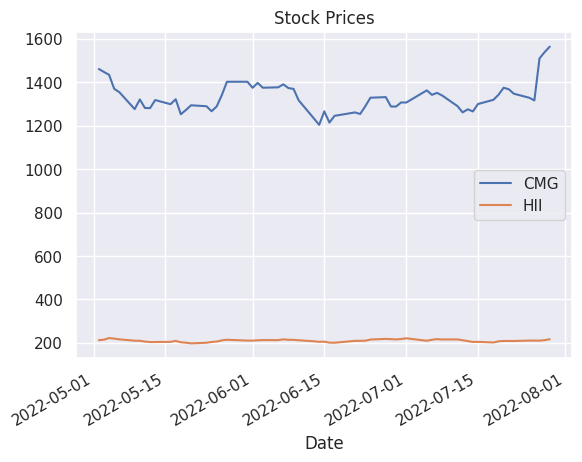

In [8]:
#visualize 
stock_price.plot()
plt.title('Stock Prices')
plt.xlabel('Date')
plt.show()

In [9]:
#get correlation
stock_price.corr()

,CMG,HII
CMG,1.000000,0.490343
HII,0.490343,1.000000


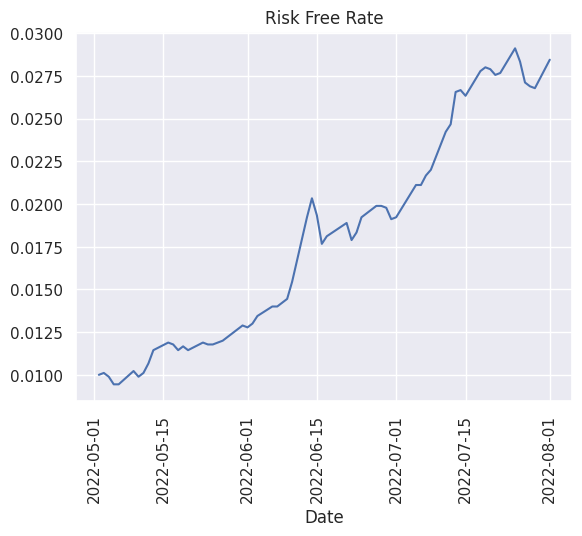

In [10]:
#get returns on stocks, and market
returns = stock_price.pct_change()
returns.dropna(inplace=True) #first entry can't be computed

#convert 3 month risk free rate into daily rate
risk_free = risk_free['2022-05-01':'2022-08-01']
risk_free = risk_free/90 
risk_free.dropna(inplace=True)

plt.plot(risk_free)
plt.title('Risk Free Rate')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

In [11]:
#to calculate excess return, subtract risk free rate from stock returns
#these excess returns will be stored in df returns

#returns.columns
for i in returns.columns:
    returns[f'excess_return_{i}'] = returns[i] - risk_free

returns.head()

,CMG,HII,excess_return_CMG,excess_return_HII
Date,,,,
2022-05-03,-0.009321,0.011444,-0.019432,0.001333
2022-05-04,-0.008988,0.034364,-0.018877,0.024475
2022-05-05,-0.045081,-0.010804,-0.054525,-0.020248
2022-05-06,-0.011191,-0.015882,-0.020635,-0.025327
2022-05-09,-0.057555,-0.028994,-0.067777,-0.039216


In [12]:
returns.columns #gone from two, to four 

Index(['CMG', 'HII', 'excess_return_CMG', 'excess_return_HII'], dtype='object')

##### 3. Run Capital Asset Pricing Model and interpret the results.

In [13]:
#need to install first
!pip3 install statsmodels
#then import
import statsmodels.api as sm

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [14]:
#CAPM analysis for Chipotle
y_cmg = returns['excess_return_CMG']
X = returns['excess_return_HII']

X = sm.add_constant(X, prepend=False)
capm_cmg = sm.OLS(y_cmg, X)
capm_result_cmg = capm_cmg.fit()

capm_result_cmg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_CMG   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.755
Date:                Mon, 03 Oct 2022   Prob (F-statistic):             0.0332
Time:                        06:18:50   Log-Likelihood:                 127.73
No. Observations:                  61   AIC:                            -251.5
Df Residuals:                      59   BIC:                            -247.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
excess_return_HII     0.4797      0.220      2.181      0.033       0.040       0.920
const                -0.0079      0.005     -1.456      0.151      -0.019       0.003
==============================================================================
Omnibus:                       38.374   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.483
Skew:                           1.746   Prob(JB):                     3.80e-30
Kurtosis:                       9.411   Cond. No.                         56.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#CAPM analysis for Huntington Ingalls
#CAPM analysis for Chipotle
y_hii = returns['excess_return_HII']
X = returns['excess_return_CMG']

X = sm.add_constant(X, prepend=False)
capm_hii = sm.OLS(y_hii, X)
capm_result_hii = capm_hii.fit()

capm_result_hii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_HII   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.755
Date:                Mon, 03 Oct 2022   Prob (F-statistic):             0.0332
Time:                        06:18:50   Log-Likelihood:                 162.09
No. Observations:                  61   AIC:                            -320.2
Df Residuals:                      59   BIC:                            -316.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
excess_return_CMG     0.1555      0.071      2.181      0.033       0.013       0.298
const                -0.0149      0.002     -5.959      0.000      -0.020      -0.010
==============================================================================
Omnibus:                        6.308   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.949
Skew:                          -0.319   Prob(JB):                       0.0188
Kurtosis:                       4.649   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Beta coefficient for Chipotle is 0.4797, while for Huntington Ingalls it is 0.1555. These betas are statistically signficant because both have p-values of .033. Chipotle has higher volatility due to the higher beta. 

##### 4. Calculate Sharpe and Treynor measures. Compare and interpret the results and conclude.

In [16]:
def sharpe(stocks, rf, n_assets):
    sharpe_ratios = {}
    for i, j in zip(stocks, range(n_assets)):
        sharpe_ratios[i] = returns.iloc[:, j].mean() - rf / np.std(returns.iloc[:, j])
    return sharpe_ratios

In [17]:
#returns.columns[:2] get names
rf = risk_free.mean()
stocks = returns.columns[:2]
sharpe_ratios = sharpe(stocks, rf, 3)
sharpe_ratios

{'CMG': -0.5660625879836825, 'HII': -1.075643798118079}

##### The higher the sharpe ratio, the better. Both ratios are below 1, which is bad. This means the risk free rate is higher than the stocks' return, or expected return will be negative.

In [18]:
betas = [capm_result_cmg.params[0],
         capm_result_hii.params[0]]
betas

[0.47970954431945795, 0.15548284196950168]

In [19]:
#get average of returns
cmg_ret = returns['CMG'].mean()
hii_ret = returns['HII'].mean()

In [20]:
ret_exp = [cmg_ret, hii_ret] #let's say expected return for both is 5%
df_ret_exp = pd.DataFrame(ret_exp)
df_betas = pd.DataFrame(betas)
df_all = pd.concat([df_betas, df_ret_exp], axis=1)
df_all.columns = ['betas', 'ret_exp']
df_all.index = returns.columns[:2]
df_all

,betas,ret_exp
CMG,0.479710,0.001604
HII,0.155483,0.000484


In [21]:
def treynor(stocks, rf, n_assets):
    treynor_ratios = {}
    for i, j in enumerate(stocks):
        treynor_ratios[j] = returns.iloc[:, i].mean() - rf / df_all['betas'][j]
    return treynor_ratios

In [22]:
treynor_ratios = treynor(stocks, rf, 3)
treynor_ratios

{'CMG': -0.035778663796765586, 'HII': -0.11485368933281442}

##### Both ratios are negative, so the calculations of this ratio doesn't mean anything. This ratio only has meaning when it is positive, a high Treynor ratio means the stock is a good investment/will give good returns.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=310a33be-f512-48c8-8707-dc5137fbcc75' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>